In [12]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [13]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [14]:
key = os.environ.get('AZURE_SEARCH_KEY', '6fc1ea2e0b5f4a1c911060ef472cf956')

In [15]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [16]:
results = search_images_bing(key, 'arara')
ims = results.attrgot('contentUrl')
len(ims)

150

In [17]:
tipos_passaros = 'Ara Ararauna','Ara macao','Ara chloroptera', 'arara azul grande', 'arara azul de lear'
path = Path('passaro_arara')

In [18]:
if not path.exists():
    path.mkdir()
    for o in tipos_passaros:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'arara{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [19]:
fns = get_image_files(path)
fns

(#717) [Path('passaro_arara/arara azul de lear/00000047.jpg'),Path('passaro_arara/arara azul de lear/00000055.jpg'),Path('passaro_arara/arara azul de lear/00000107.jpg'),Path('passaro_arara/arara azul de lear/00000036.jpg'),Path('passaro_arara/arara azul de lear/00000030.jpg'),Path('passaro_arara/arara azul de lear/00000097.jpg'),Path('passaro_arara/arara azul de lear/00000148.jpg'),Path('passaro_arara/arara azul de lear/00000110.jpg'),Path('passaro_arara/arara azul de lear/00000029.jpg'),Path('passaro_arara/arara azul de lear/00000091.jpg')...]

In [20]:
failed = verify_images(fns)
failed

(#19) [Path('passaro_arara/arara azul de lear/00000134.jpg'),Path('passaro_arara/arara azul de lear/00000056.jpg'),Path('passaro_arara/Ara Ararauna/00000047.jpg'),Path('passaro_arara/Ara Ararauna/00000000.jpg'),Path('passaro_arara/Ara Ararauna/00000099.jpg'),Path('passaro_arara/Ara Ararauna/00000093.png'),Path('passaro_arara/Ara Ararauna/00000008.jpg'),Path('passaro_arara/Ara Ararauna/00000007.jpg'),Path('passaro_arara/Ara Ararauna/00000042.png'),Path('passaro_arara/Ara Ararauna/00000121.jpg')...]

In [21]:
failed.map(Path.unlink);

In [22]:
passaros = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [23]:
dls = passaros.dataloaders(path)

In [25]:
passaros = passaros.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = passaros.dataloaders(path)

In [26]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.461748,1.596604,0.510791,00:11


epoch,train_loss,valid_loss,error_rate,time
0,1.355144,0.780856,0.266187,00:13
1,1.073298,0.655923,0.230216,00:14
2,0.933658,0.639428,0.223022,00:13
3,0.814496,0.613812,0.230216,00:14


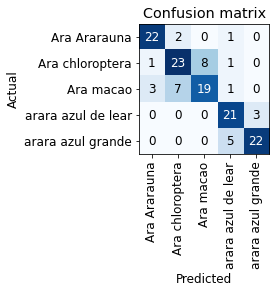

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

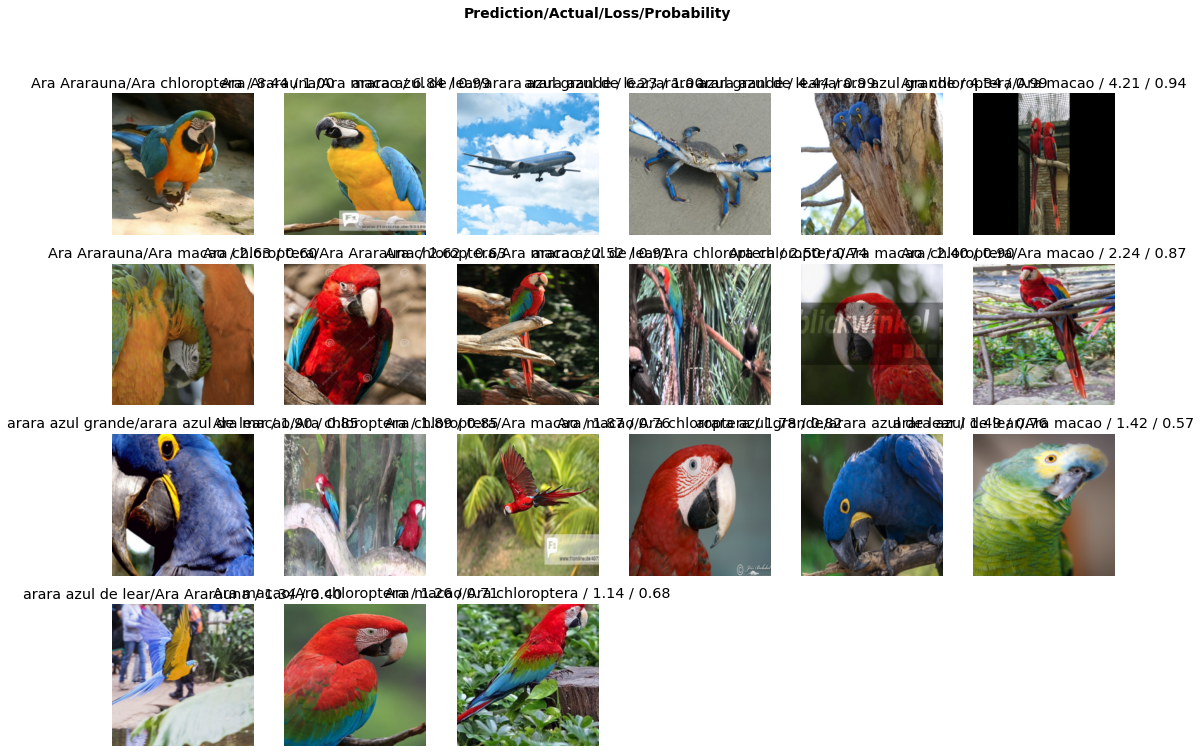

In [32]:
interp.plot_top_losses(21, nrows=4)

In [33]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [34]:
#hide
#Nesta célula, as imagens classificadas para outras pastas no bloco anterior, são movidas para as pastas corrigidas
name = 150
for idx, cat in cleaner.change():
    path_origem = str(cleaner.fns[idx])
    path_destino = path/cat/f"{name}.{path_origem.split('.')[-1]}" #aqui, é para não ocorrer repetição de nome entre as imagens

    shutil.move(path_origem, path_destino) #comando para mudar as imagens de pasta
    name += 1

In [48]:
learn.export('arara.pkl')

In [65]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.7 MB 20.0 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 32.0 MB/s eta 0:00:01
     |████████████████████████████████| 397 kB 30.3 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 15.9 MB/s eta 0:00:01
     |████████████████████████████████| 558 kB 26.9 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 13.8 MB/s eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbdev 1.1.23 requires nbconvert<6, but you have nbconvert 6.4.2 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.3.1 OK


In [49]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('arara.pkl')]

In [50]:
learn_inf = load_learner(path/'arara.pkl')

In [52]:
learn_inf.predict('passaro_arara/Ara_chloroptera/00000002.jpg')

('Ara chloroptera',
 TensorBase(1),
 TensorBase([2.4460e-04, 9.3823e-01, 6.1266e-02, 3.2642e-05, 2.2997e-04]))

In [53]:
learn_inf.dls.vocab

['Ara Ararauna', 'Ara chloroptera', 'Ara macao', 'arara azul de lear', 'arara azul grande']

In [54]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [56]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['passaro_arara/Ara_chloroptera/00000002.jpg'])

In [57]:
img = PILImage.create(btn_upload.data[-1])

In [58]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [59]:
pred,pred_idx,probs = learn_inf.predict(img)

In [60]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Predição: {pred}; Probabilidade: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Predição: Ara chloroptera; Probabilidade: 0.9382')

In [61]:
#hide_output
btn_run = widgets.Button(description='Classificação')
btn_run

Button(description='Classificação', style=ButtonStyle())

In [62]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Predição: {pred}; Probabilidade: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [63]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [67]:
#hide_output
VBox([widgets.Label('Selecionar seu passaro!'), 
      btn_upload, btn_run, out_pl, lbl_pred])